In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

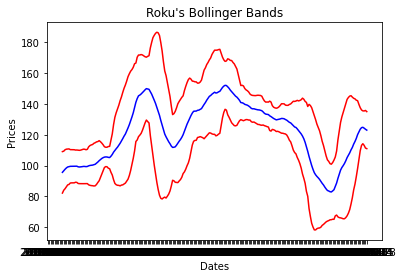

In [2]:
# Bollinger Bands
data_roku = pd.read_csv('/Users/zitaosong/Desktop/data/ROKU.csv')
data_rokuroku = pd.DataFrame(data_roku)
day_MA_30 = data_roku['Adj Close'].rolling(window=20).mean()
st_dev_30 = data_roku['Adj Close'].rolling(window=20).std()
upper_bound = day_MA_30+(st_dev_30*2)
lower_bound = day_MA_30-(st_dev_30*2)
day_MA_30.index = data_roku['Date']
plt.plot(day_MA_30, 'b')
plt.plot(upper_bound, 'r')
plt.plot(lower_bound, 'r')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.title("Roku's Bollinger Bands")
plt.show()

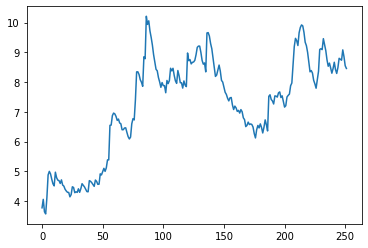

In [3]:
#Average true range (ATR)
def average_true_range(data, trend_periods=14, open_col='Open', high_col='High', low_col='Low',
                       close_col='Close', drop_tr=True):
    for index, row in data.iterrows():
        prices = [row[high_col], row[low_col], row[close_col], row[open_col]]
        if index > 0:
            val1 = np.amax(prices) - np.amin(prices)
            val2 = abs(np.amax(prices) - data.at[index - 1, close_col])
            val3 = abs(np.amin(prices) - data.at[index - 1, close_col])
            true_range = np.amax([val1, val2, val3])

        else:
            true_range = np.amax(prices) - np.amin(prices)

        data.at[index, 'true_range']=true_range
    data['atr'] = data['true_range'].ewm(ignore_na=False, min_periods=0, com=trend_periods, adjust=True).mean()
    if drop_tr:
        data = data.drop(['true_range'], axis=1)
        return data
plt.plot((average_true_range(data_roku))['atr'])
plt.show()

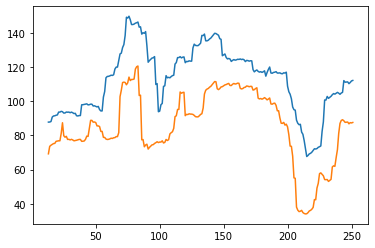

In [4]:
#Chandelier Exit
def chandelier_exit(data):
    index=data.index
    long_exit = (data['Close'].rolling(window=14).max())-(average_true_range(data)['atr'])*3
    short_exit = (data['Close'].rolling(window=14).min())-(average_true_range(data)['atr'])*3
    data.at[index, 'long exit']=long_exit
    data.at[index, 'short exit']=short_exit
    return data
plt.plot(chandelier_exit(data_roku)['long exit'])
plt.plot(chandelier_exit(data_roku)['short exit'])
plt.show()

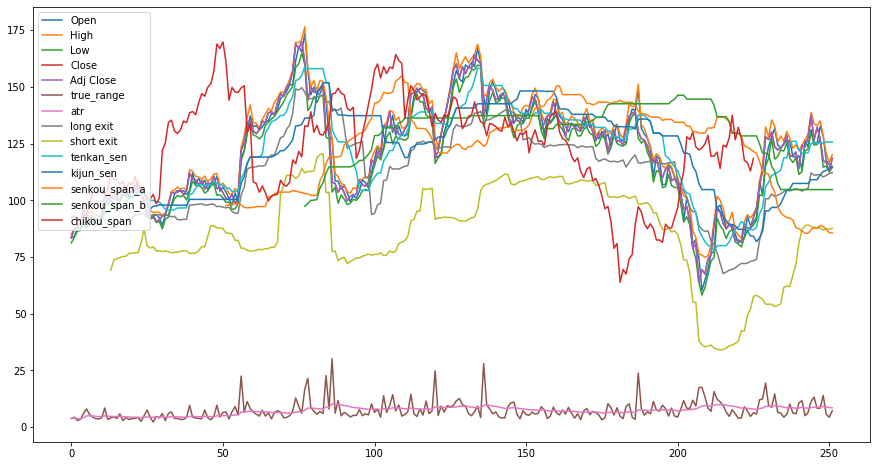

In [5]:
#Ichimoku Cloud
d = pd.DataFrame(data_roku)
d['Dates']=data_roku['Date']
nine_period_high = d['High'].rolling(window= 9).max()
nine_period_low = d['Low'].rolling(window= 9).min()
d['tenkan_sen'] = (nine_period_high + nine_period_low) /2
period26_high = d['High'].rolling(window=26).max()
period26_low = d['Low'].rolling(window=26).min()
d['kijun_sen'] = (period26_high + period26_low) / 2
d['senkou_span_a'] = ((d['tenkan_sen'] + d['kijun_sen']) / 2).shift(26)
period52_high = d['High'].rolling(window=52).max()
period52_low = d['Low'].rolling(window=52).min()
d['senkou_span_b'] = ((period52_high + period52_low) / 2).shift(26)
d['chikou_span'] = d['Close'].shift(-26)
d.drop(['Dates', 'Volume'], axis=1).plot(figsize=(15,8))
plt.legend(loc='upper left')
plt.show()

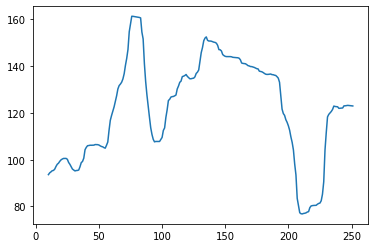

In [6]:
#KAMA
d = pd.DataFrame(data_roku)
def KAMA(price, n=10, pow1=2, pow2=30):
    absDiffx = abs(price - price.shift(1) )

    ER_num = abs( price - price.shift(n) )
    ER_den = absDiffx.rolling(window=10).sum()
    ER = ER_num / ER_den

    sc = ( ER*(2.0/(pow1+1)-2.0/(pow2+1.0))+2/(pow2+1.0) ) ** 2.0


    answer = np.zeros(sc.size)
    N = len(answer)
    first_value = True

    for i in range(N):
        if sc[i] != sc[i]:
            answer[i] = np.nan
        else:
            if first_value:
                answer[i] = price[i]
                first_value = False
            else:
                answer[i] = answer[i-1] + sc[i] * (price[i] - answer[i-1])
    return answer

kama = KAMA(d.Close, n=10, pow1=2, pow2=30)
plt.plot(kama)
plt.show()

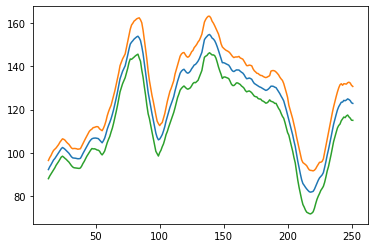

In [7]:
#Keltner Channel
def keltner_channel(df, n=14):
    KelChM = pd.Series(((df['High'] + df['Low'] + df['Close']) / 3).rolling(n, min_periods=n).mean(),
                       name='KelChM_' + str(n))
    KelChU = pd.Series(((4 * df['High'] - 2 * df['Low'] + df['Close']) / 3).rolling(n, min_periods=n).mean(),
                       name='KelChU_' + str(n))
    KelChD = pd.Series(((-2 * df['High'] + 4 * df['Low'] + df['Close']) / 3).rolling(n, min_periods=n).mean(),
                       name='KelChD_' + str(n))
    df = df.join(KelChM)
    df = df.join(KelChU)
    df = df.join(KelChD)
    return df
plt.plot(keltner_channel(data_roku)['KelChM_14'])
plt.plot(keltner_channel(data_roku)['KelChU_14'])
plt.plot(keltner_channel(data_roku)['KelChD_14'])
plt.show()

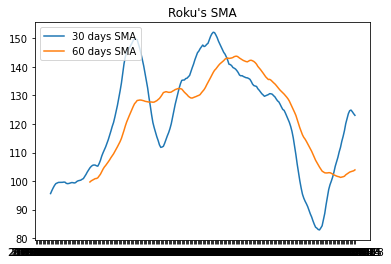

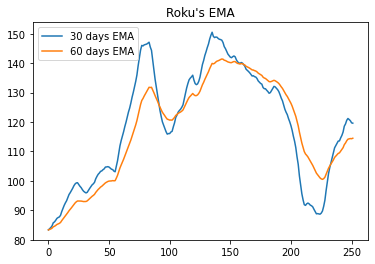

In [8]:
#Moving Average
# simple moving average
rolling_mean = data_roku['Adj Close'].rolling(window=20).mean()
rolling_mean1 = data_roku['Adj Close'].rolling(window=50).mean()
rolling_mean1.index = data_roku['Date']
plt.plot(rolling_mean, label='30 days SMA')
plt.plot(rolling_mean1, label='60 days SMA')
plt.legend(loc='upper left')
plt.title("Roku's SMA")
plt.show()
# exponential moving average (EMA)
exp1 = data_roku['Adj Close'].ewm(span=20, adjust=False).mean()
exp2 = data_roku['Adj Close'].ewm(span=50, adjust=False).mean()
plt.plot(exp1, label='30 days EMA')
plt.plot(exp2, label='60 days EMA')
plt.legend(loc='upper left')
plt.title("Roku's EMA")
plt.show()

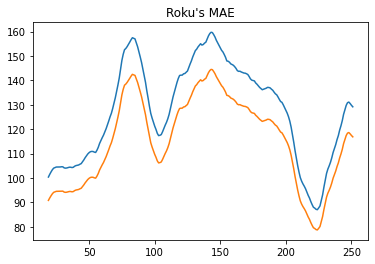

In [9]:
#Moving Average Envelops
k = 0.05
upper_bound1 = rolling_mean*(1+k)
lower_bound1 = rolling_mean*(1-k)
plt.plot(upper_bound1)
plt.plot(lower_bound1)
plt.title("Roku's MAE")
plt.show()


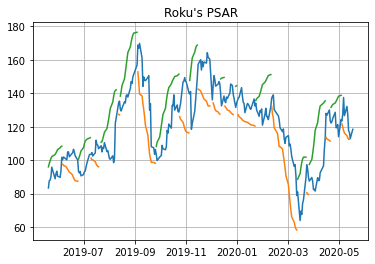

In [10]:
#Parabolic SAR
def psar(barsdata, iaf=0.02, maxaf=0.2):
    length = len(barsdata)
    dates = list(barsdata['Date'])
    high = list(barsdata['High'])
    low = list(barsdata['Low'])
    close = list(barsdata['Close'])
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
    bull = True
    af = iaf
    ep = low[0]
    hp = high[0]
    lp = low[0]

    for i in range(2, length):
        if bull:
            psar[i] = psar[i - 1] + af * (hp - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (lp - psar[i - 1])

        reverse = False

        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = hp
                lp = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = lp
                hp = high[i]
                af = iaf

        if not reverse:
            if bull:
                if high[i] > hp:
                    hp = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < lp:
                    lp = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]

        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]

    return {"dates": dates, "high": high, "low": low, "close": close, "psar": psar, "psarbear": psarbear,
            "psarbull": psarbull}

barsdata = data_roku
barsdata = barsdata.reindex(index=barsdata.index[::-1])
barsdata['Date'] = [datetime.strptime(x, '%Y-%m-%d') for x in barsdata['Date']]
startidx = 0
endidx = len(barsdata)
result = psar(barsdata)
dates = result['dates'][startidx:endidx]
close = result['close'][startidx:endidx]
psarbear = result['psarbear'][startidx:endidx]
psarbull = result['psarbull'][startidx:endidx]
plt.plot(dates, close)
plt.plot(dates, psarbull)
plt.plot(dates, psarbear)
plt.grid()
plt.title("Roku's PSAR")
plt.show()


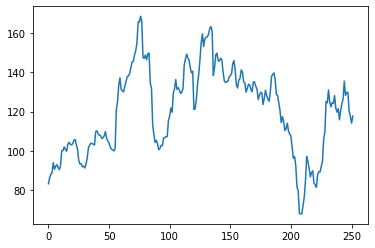

In [11]:
#Pivot Points
def PPSR(data):
    PP = pd.Series((data['High'] + data['Low'] + data['Close']) / 3)
    R1 = pd.Series(2 * PP - data['Low'])
    S1 = pd.Series(2 * PP - data['High'])
    R2 = pd.Series(PP + data['High'] - data['Low'])
    S2 = pd.Series(PP - data['High'] + data['Low'])
    R3 = pd.Series(data['High'] + 2 * (PP - data['Low']))
    S3 = pd.Series(data['Low'] - 2 * (data['High'] - PP))
    psr = {'PP':PP, 'R1':R1, 'S1':S1, 'R2':R2, 'S2':S2, 'R3':R3, 'S3':S3}
    PSR = pd.DataFrame(psr)
    data = data.join(PSR)
    return data
plt.plot(PPSR(data_roku)['PP'])
plt.show()

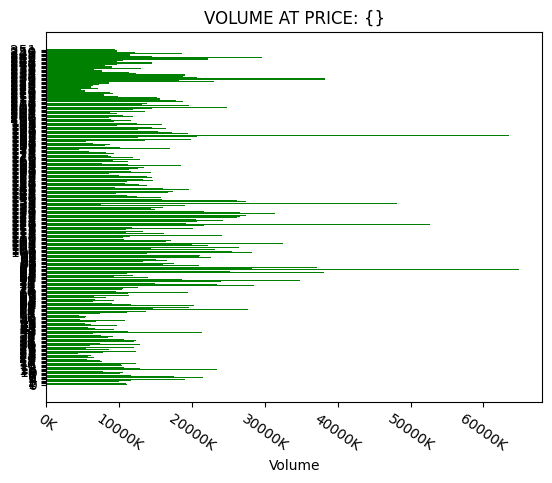

None


In [12]:
#PBV
import quandl
from matplotlib.ticker import FuncFormatter
import argparse
def parse_args():
    parser = argparse.ArgumentParser(description='Volume at Price Chart')
    parser.add_argument('qcode', help='The Quandle code, including database \
                        prefix e.g. WIKI/F of the instrument being tested')
    parser.add_argument('start', help='Starting date in YYYY-MM-DD format')
    parser.add_argument('end', help='Ending date in YYYY-MM-DD format')
    parser.add_argument('round', type=int, help='Round to the Nearest')
    return parser.parse_args()
def get_quandl_data(ticker, start, end):
    data = quandl.get(ticker, start_date=start, end_date=end)
    return data
def custom_round(x, base=5):
    return int(base * round(float(x) / base))
def round_and_group(df, base=5):
    df = data[['Close', 'Volume']].copy()
    df['Close'] = df['Close'].apply(lambda x: custom_round(x, base=base))
    df = df.set_index('Close')
    df = df.groupby(['Close']).sum()
    return df
def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)


def create_plot(x_series, x_label, y_pos, y_tick_labels, colour, title):

    plt.rcdefaults()
    fig, ax = plt.subplots()

    ax.barh(y_pos, x_series, align='center', color=colour)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_tick_labels)
    formatter = FuncFormatter(thousands)
    ax.xaxis.set_major_formatter(formatter)
    ax.set_xlabel(x_label)
    ax.set_title(title)
    plt.xticks(rotation=325)
    plt.show()

quandl_api = "INSERT YOUR API KEY"
quandl.ApiConfig.api_key = quandl_api
data = data_roku
y_pos = np.arange(len(data.index.values))

plt = create_plot(data['Volume'], 'Volume', y_pos, data.index.values, 'Green', 'VOLUME AT PRICE: {}')
print(plt)


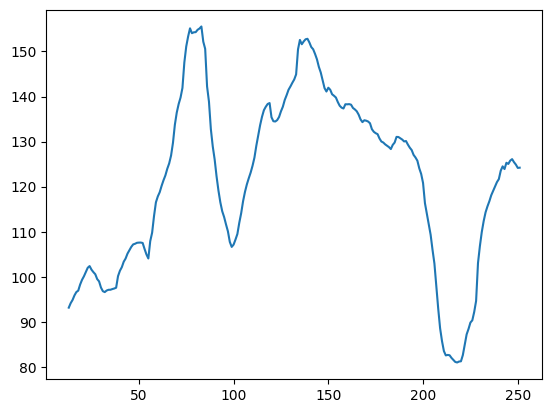

In [24]:
import matplotlib.pyplot as plt
#VWAP
def VWAP(data, n=14):
    price = data['Close']
    volume = data['Volume']
    vwap = ((price*volume).rolling(window=n).sum())/(volume.rolling(window=n).sum())
    return vwap
plt.plot(VWAP(data_roku))
plt.show()


<ipython-input-25-0bc01f53f1c8>:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dfPrices.price = data_roku['Close']
<ipython-input-25-0bc01f53f1c8>:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dfPrices.ix = data_roku.index


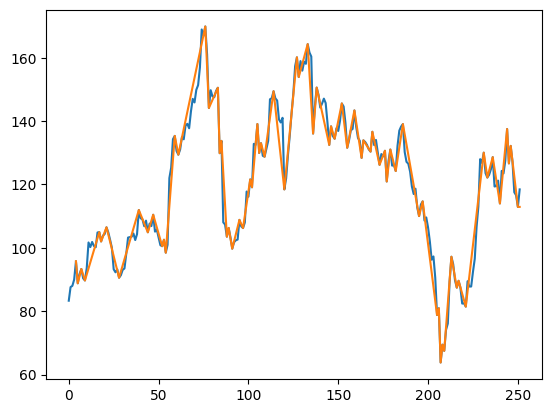

In [25]:
#ZigZag
dfPrices = data_roku
dfPrices.price = data_roku['Close']
dfPrices.ix = data_roku.index
dfReturns = dfPrices.price - dfPrices.price.shift(1)
dfReturnsPrc = dfReturns / dfPrices.price.shift(1)*100
def createZigZagPoints(dfSeries, minSegSize=2, sizeInDevs=1):
    minRetrace = minSegSize

    curVal = dfSeries[0]
    curPos = dfSeries.index[0]
    curDir = 1
    # dfRes = pd.DataFrame(np.zeros((len(dfSeries.index), 2)), index=dfSeries.index, columns=["Dir", "Value"])
    dfRes = pd.DataFrame(index=dfSeries.index, columns=["Dir", "Value"])
    # print(dfRes)
    # print(len(dfSeries.index))
    for ln in dfSeries.index:
        if ((dfSeries[ln] - curVal) * curDir >= 0):
            curVal = dfSeries[ln]
            curPos = ln
            # print(str(ln) + ": moving curVal further, to " + str(curVal))
        else:
            retracePrc = abs((dfSeries[ln] - curVal) / curVal * 100)
            # print(str(ln) + ": estimating retracePrc, it's " + str(retracePrc))
            if (retracePrc >= minRetrace):
                # print(str(ln) + ": registering key point, its pos is " + str(curPos) + ", value = " + str(curVal) + ", dir=" +str(curDir))
                dfRes.at[curPos, 'Value'] = curVal
                dfRes.at[curPos, 'Dir'] = curDir
                curVal = dfSeries[ln]
                curPos = ln
                curDir = -1 * curDir
                # print(str(ln) + ": setting new cur vals, pos is " + str(curPos) + ", curVal = " + str(curVal) + ", dir=" +str(curDir))
        # print(ln, curVal, curDir)
    dfRes[['Value']] = dfRes[['Value']].astype(float)
    dfRes = dfRes.interpolate(method='linear')
    return (dfRes)


dfRes = createZigZagPoints(dfPrices.price)
plt.plot(dfPrices['Close'])
plt.plot(dfRes['Value'])
plt.show()

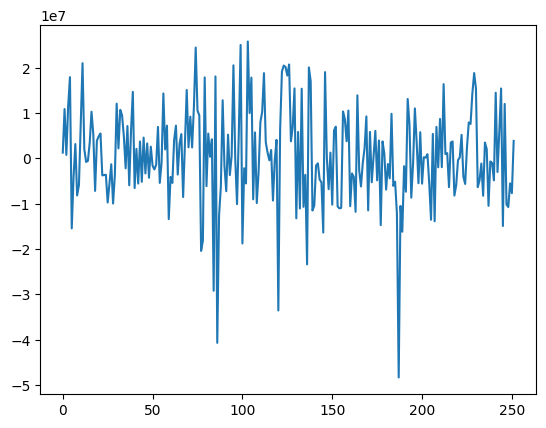

In [26]:
#Accumulation Distribution
def acc_dist(data, trend_periods=21, open_col='Open', high_col='High', low_col='Low', close_col='Close',
             vol_col='Volume'):
    for index, row in data.iterrows():
        if row[high_col] != row[low_col]:
            ac = ((row[close_col] - row[low_col]) - (row[high_col] - row[close_col])) / (row[high_col] - row[low_col]) * \
                 row[vol_col]
        else:
            ac = 0
        data.at[index, 'acc_dist'] = ac
    data['acc_dist_ema' + str(trend_periods)] = data['acc_dist'].ewm(ignore_na=False, min_periods=0, com=trend_periods,
                                                                     adjust=True).mean()

    return data
plt.plot((acc_dist(data_roku))['acc_dist'])
plt.show()

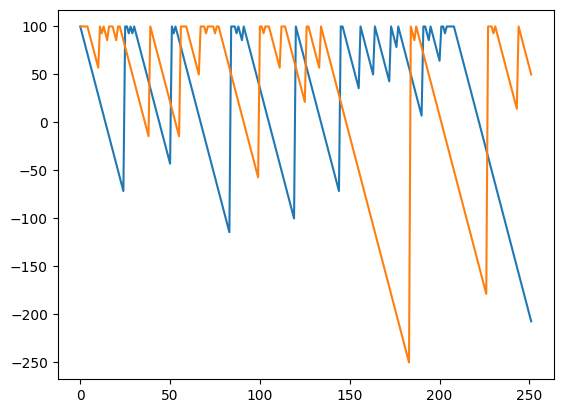

In [27]:
#Aroon
def aroon():
    df_aroon = data_roku
    df_aroon['14L_min'] = df_aroon['Low'].rolling(window=14,min_periods=0).min()
    df_aroon['14H_max'] = df_aroon['High'].rolling(window=14,min_periods = 0).max()
    df_aroon['ind'] = range(0,len(df_aroon))
    # recent_high = df_aroon.iloc[-1]["25d High"]
    df_aroon['high_ind'] = df_aroon['ind'].where(df_aroon["14H_max"]==df_aroon['High']).fillna(method = 'ffill')
    df_aroon['low_ind'] = df_aroon['ind'].where(df_aroon["14L_min"] == df_aroon['Low']).fillna(method = 'ffill')
    df_aroon['since_high'] = df_aroon['ind']-df_aroon['high_ind']
    df_aroon['since_low'] = df_aroon['ind'] - df_aroon['low_ind']
    df_aroon['up'] = (((14 - df_aroon['since_high'])/14) *100)
    df_aroon['down'] = (((14 - df_aroon['since_low']) / 14) * 100)
    return (df_aroon)

plt.plot(aroon()[['down', 'up']])
plt.show()

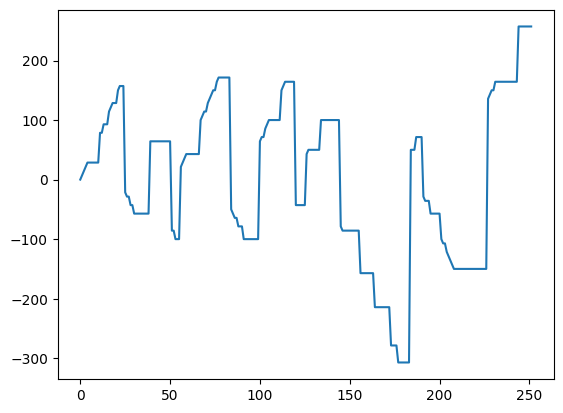

In [28]:
#Aroon oscillator
def aroon_oscillator():
    df_aroon=aroon()
    aroon_oscillator = df_aroon['up']-df_aroon['down']
    return aroon_oscillator
plt.plot(aroon_oscillator())
plt.show()


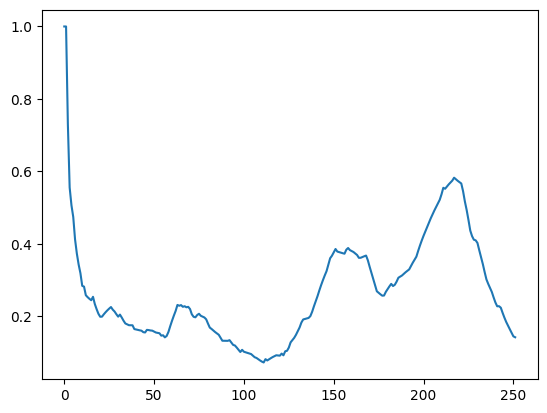

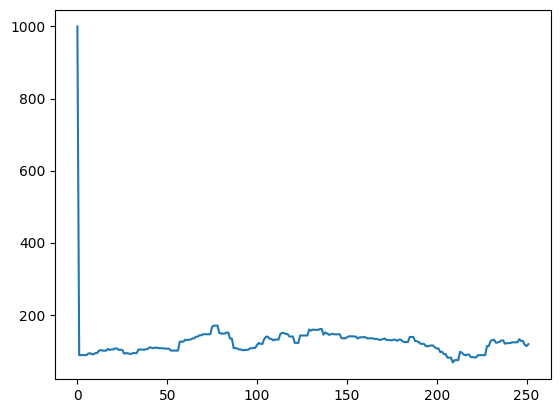

In [29]:
# Average Directional Index (ADX)
def directional_movement_index(data, periods=14, high_col='High', low_col='Low'):
    remove_tr_col = False
    if not 'true_range' in data.columns:
        data = average_true_range(data, drop_tr=False)
        remove_tr_col = True

    data['m_plus'] = 0.
    data['m_minus'] = 0.

    for i, row in data.iterrows():
        if i > 0:
            data.at[i, 'm_plus'] = row[high_col] - data.at[i - 1, high_col]
            data.at[i, 'm_minus'] = row[low_col] - data.at[i - 1, low_col]

    data['dm_plus'] = 0.
    data['dm_minus'] = 0.

    for i, row in data.iterrows():
        if row['m_plus'] > row['m_minus'] and row['m_plus'] > 0:
            data.at[i, 'dm_plus'] = row['m_plus']

        if row['m_minus'] > row['m_plus'] and row['m_minus'] > 0:
            data.at[i, 'dm_minus'] = row['m_minus']
    data['di_plus'] = (data['dm_plus'] / data['true_range']).ewm(ignore_na=False, min_periods=0, com=periods,
                                                                 adjust=True).mean()
    data['di_minus'] = (data['dm_minus'] / data['true_range']).ewm(ignore_na=False, min_periods=0, com=periods,
                                                                   adjust=True).mean()

    data['dxi'] = np.abs(data['di_plus'] - data['di_minus']) / (data['di_plus'] + data['di_minus'])
    data.at[0, 'dxi']=1.
    data['adx'] = data['dxi'].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean()
    data = data.drop(['m_plus', 'm_minus', 'dm_plus', 'dm_minus'], axis=1)
    if remove_tr_col:
        data = data.drop(['true_range'], axis=1)

    return data
plt.plot((directional_movement_index(data_roku))['adx'])
plt.show()


def negative_volume_index(data, periods=255, close_col='Close', vol_col='Volume'):
    data['nvi'] = 0.

    for index, row in data.iterrows():
        if index > 0:
            prev_nvi = data.at[index - 1, 'nvi']
            prev_close = data.at[index - 1, close_col]
            if row[vol_col] < data.at[index - 1, vol_col]:
                nvi = prev_nvi + (row[close_col] - prev_close / prev_close * prev_nvi)
            else:
                nvi = prev_nvi
        else:
            nvi = 1000
        data.at[index, 'nvi'] = nvi
    data['nvi_ema'] = data['nvi'].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean()

    return data


plt.plot((negative_volume_index(data_roku))['nvi'])
plt.show()


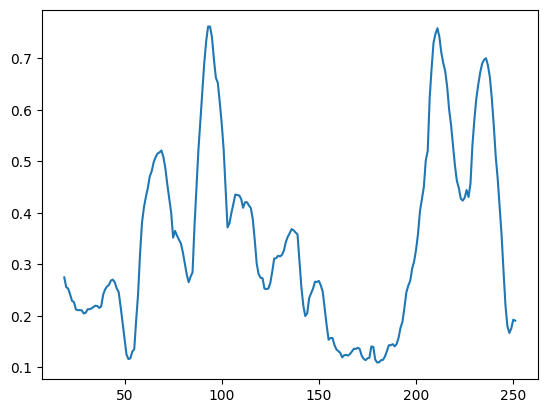

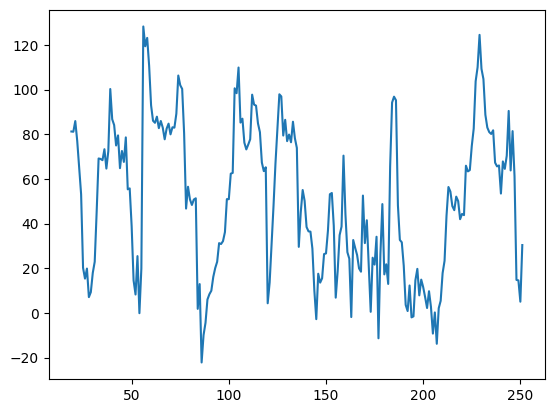

In [30]:
#Bandwidth
from pyti import catch_errors
from pyti.function_helper import fill_for_noncomputable_vals
from pyti.simple_moving_average import (
    simple_moving_average as sma
    )
from six.moves import range
def upper_bollinger_band(data, period, std_mult=2.0):
    catch_errors.check_for_period_error(data, period)

    period = int(period)
    simple_ma = sma(data, period)[period-1:]

    upper_bb = []
    for idx in range(len(data) - period + 1):
        std_dev = np.std(data[idx:idx + period])
        upper_bb.append(simple_ma[idx] + std_dev * std_mult)
    upper_bb = fill_for_noncomputable_vals(data, upper_bb)

    return np.array(upper_bb)


def middle_bollinger_band(data, period, std=2.0):
    catch_errors.check_for_period_error(data, period)

    period = int(period)
    mid_bb = sma(data, period)

    return mid_bb


def lower_bollinger_band(data, period, std=2.0):
    catch_errors.check_for_period_error(data, period)

    period = int(period)
    simple_ma = sma(data, period)[period-1:]

    lower_bb = []
    for idx in range(len(data) - period + 1):
        std_dev = np.std(data[idx:idx + period])
        lower_bb.append(simple_ma[idx] - std_dev * std)
    lower_bb = fill_for_noncomputable_vals(data, lower_bb)

    return np.array(lower_bb)


def bandwidth(data, period, std=2.0):
    catch_errors.check_for_period_error(data, period)

    period = int(period)
    bandwidth = ((upper_bollinger_band(data, period, std) -
                 lower_bollinger_band(data, period, std)) /
                 middle_bollinger_band(data, period, std)
                 )

    return bandwidth
plt.plot(bandwidth(data_roku['Close'], period=20))
plt.show()

#%B
def percent_b(data, period, upper_bb_std=2.0, lower_bb_std=2.0):
    lb = lower_bollinger_band(data, period, lower_bb_std)
    ub = upper_bollinger_band(data, period, upper_bb_std)
    percent_b = ((np.array(data) - lb) / (ub - lb)) * 100
    return percent_b
plt.plot(percent_b(data_roku['Close'], period=20))
plt.show()

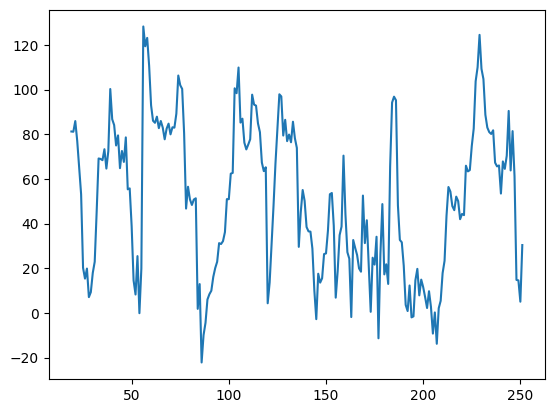

In [31]:
#%B
def percent_b(data, period, upper_bb_std=2.0, lower_bb_std=2.0):
    lb = lower_bollinger_band(data, period, lower_bb_std)
    ub = upper_bollinger_band(data, period, upper_bb_std)
    percent_b = ((np.array(data) - lb) / (ub - lb)) * 100
    return percent_b
plt.plot(percent_b(data_roku['Close'], period=20))
plt.show()


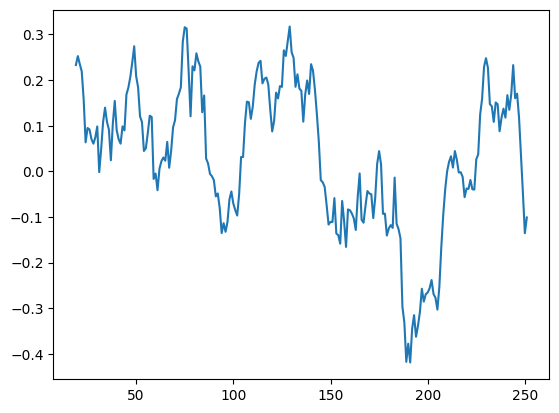

In [32]:
#Chaikin Money Flow (CMF)
def chaikin_money_flow(close_data, high_data, low_data, volume, period):
    catch_errors.check_for_input_len_diff(
        close_data, high_data, low_data, volume)
    catch_errors.check_for_period_error(close_data, period)

    close_data = np.array(close_data)
    high_data = np.array(high_data)
    low_data = np.array(low_data)
    volume = np.array(volume)
    cmf = [sum((((close_data[idx+1-period:idx+1] - low_data[idx+1-period:idx+1]) -
            (high_data[idx+1-period:idx+1] - close_data[idx+1-period:idx+1])) /
            (high_data[idx+1-period:idx+1] - low_data[idx+1-period:idx+1])) *
            volume[idx+1-period:idx+1]) / sum(volume[idx+1-period:idx+1]) for idx in range(period-1, len(close_data))]
    cmf = fill_for_noncomputable_vals(close_data, cmf)
    return cmf
plt.plot(chaikin_money_flow(close_data=data_roku['Close'], high_data=data_roku['High'], low_data=data_roku['Low'], volume=data_roku['Volume'], period=20))
plt.show()

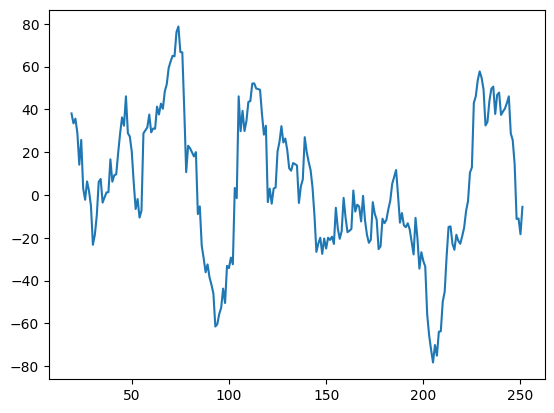

In [33]:
#Chande Momentum Oscillator
import warnings
from pyti import catch_errors
from six.moves import range
def chande_momentum_oscillator(close_data, period):
    catch_errors.check_for_period_error(close_data, period)

    close_data = np.array(close_data)

    moving_period_diffs = [[(close_data[idx+1-period:idx+1][i] -
                 close_data[idx+1-period:idx+1][i-1]) for i in range(1, len(close_data[idx+1-period:idx+1]))] for idx in range(0, len(close_data))]

    sum_up = []
    sum_down = []
    for period_diffs in moving_period_diffs:
        ups = [val if val > 0 else 0 for val in period_diffs]
        sum_up.append(sum(ups))
        downs = [abs(val) if val < 0 else 0 for val in period_diffs]
        sum_down.append(sum(downs))

    sum_up = np.array(sum_up)
    sum_down = np.array(sum_down)
    # numpy is able to handle dividing by zero and makes those calculations
    # nans which is what we want, so we safely suppress the RuntimeWarning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        cmo = 100 * ((sum_up - sum_down) / (sum_up + sum_down))
    return cmo
plt.plot(chande_momentum_oscillator(data_roku['Close'],period=20))
plt.show()

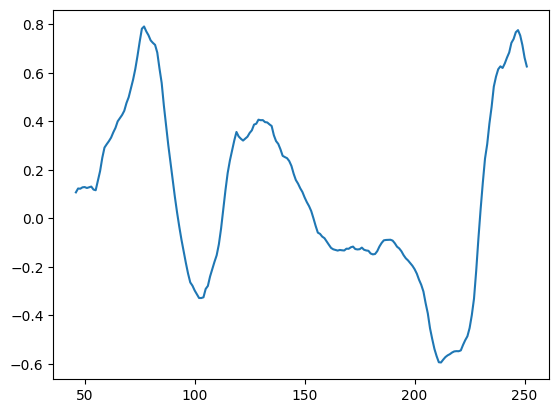

In [34]:
#Coppock Curve
def coppock_curve(df, n):
    M = df['Close'].diff(int(n * 11 / 10) - 1)
    N = df['Close'].shift(int(n * 11 / 10) - 1)
    ROC1 = M / N
    M = df['Close'].diff(int(n * 14 / 10) - 1)
    N = df['Close'].shift(int(n * 14 / 10) - 1)
    ROC2 = M / N
    Copp = pd.Series((ROC1 + ROC2).ewm(span=n, min_periods=n).mean(), name='Copp_' + str(n))
    df = df.join(Copp)
    return df
plt.plot(coppock_curve(data_roku, n=20)['Copp_20'])
plt.show()

In [35]:
from pyti.function_helper import fill_for_noncomputable_vals
from six.moves import range

#Detrended Price Oscillator (DPO)
def detrended_price_oscillator(data, period):
    catch_errors.check_for_period_error(data, period)
    period = int(period)
    dop = [data[idx] - np.mean(data[idx+1-(int(period/2)+1):idx+1]) for idx in range(period-1, len(data))]
    dop = fill_for_noncomputable_vals(data, dop)
    return dop
plt.plot(detrended_price_oscillator(data_roku, period=20))
plt.show()

KeyError: 19

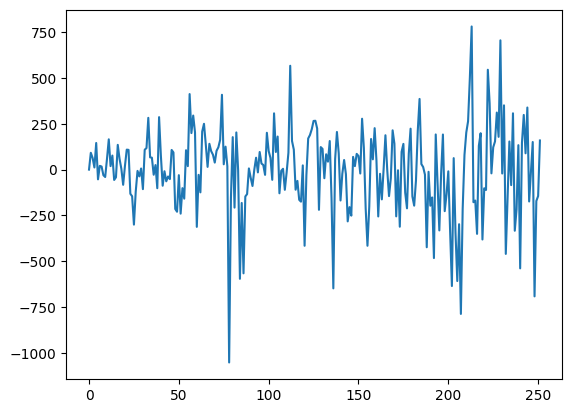

In [36]:
# Ease of Movement (EMV)
def ease_of_movement(data, period=14, high_col='High', low_col='Low', vol_col='Volume'):
    for index, row in data.iterrows():
        if index > 0:
            midpoint_move = (row[high_col] + row[low_col]) / 2 - (
                    data.at[index - 1, high_col] + data.at[index - 1, low_col]) / 2
        else:
            midpoint_move = 0

        diff = row[high_col] - row[low_col]

        if diff == 0:
            # this is to avoid division by zero below
            diff = 0.000000001

        vol = row[vol_col]
        if vol == 0:
            vol = 1
        box_ratio = (vol / 100000000) / (diff)
        emv = midpoint_move / box_ratio

        data.at[index, 'emv'] = emv

    data['emv_ema_' + str(period)] = data['emv'].ewm(ignore_na=False, min_periods=0, com=period, adjust=True).mean()

    return data


plt.plot((ease_of_movement(data_roku))['emv'])
plt.show()

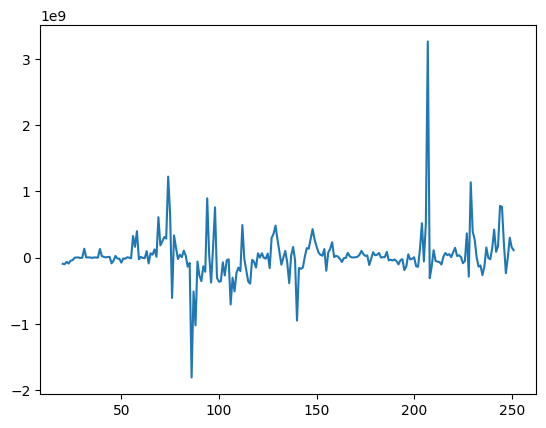

In [37]:
#Force index
def force_index(df, n):
    F = pd.Series(df['Close'].diff(n) * df['Volume'].diff(n), name='Force_' + str(n))
    df = df.join(F)
    return df
plt.plot(force_index(data_roku, n=20)['Force_20'])
plt.show()

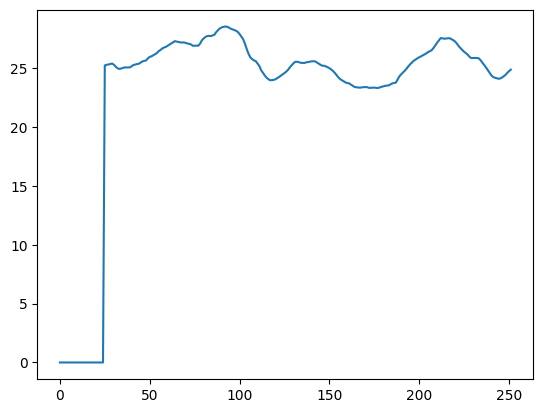

In [38]:
# Mass Index
def mass_index(data, period=25, ema_period=9, high_col='High', low_col='Low'):
    high_low = data[high_col] - data[low_col] + 0.000001  # this is to avoid division by zero below
    ema = high_low.ewm(ignore_na=False, min_periods=0, com=ema_period, adjust=True).mean()
    ema_ema = ema.ewm(ignore_na=False, min_periods=0, com=ema_period, adjust=True).mean()
    div = ema / ema_ema

    for index, row in data.iterrows():
        if index >= period:
            val = div[index - 25:index].sum()
        else:
            val = 0
        data.at[index, 'mass_index'] = val

    return data


plt.plot((mass_index(data_roku))['mass_index'])
plt.show()


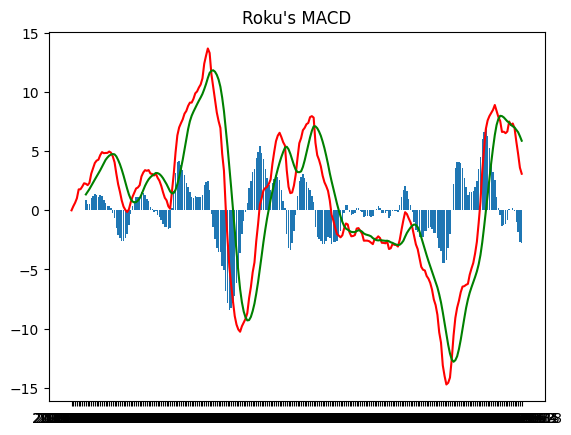

In [39]:
#MACD
exp3 = data_roku['Adj Close'].ewm(span=12, adjust=False).mean()
exp4 = data_roku['Adj Close'].ewm(span=26, adjust=False).mean()
macd = exp3-exp4
macd.index = data_roku['Date']
signal = macd.rolling(window=9).mean()
difference = macd-signal
plt.plot(macd, 'r')
plt.plot(signal, 'g')
plt.bar(data_roku["Date"], difference)
plt.title("Roku's MACD")
plt.show()

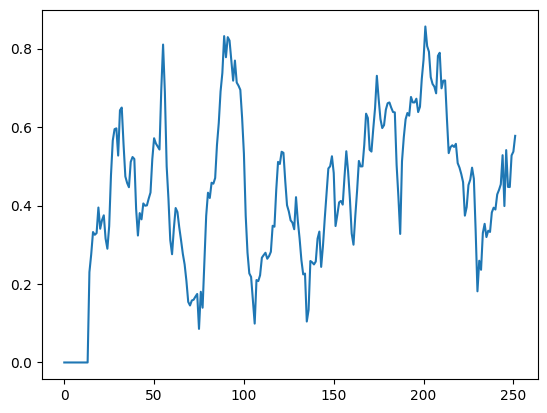

In [40]:
#Money Flow Index (MFI)
def typical_price(data, high_col='High', low_col='Low', close_col='Close'):
    data['typical_price'] = (data[high_col] + data[low_col] + data[close_col]) / 3

    return data

def money_flow_index(data, periods=14, vol_col='Volume'):
    remove_tp_col = False
    if not 'typical_price' in data.columns:
        data = typical_price(data)
        remove_tp_col = True

    data['money_flow'] = data['typical_price'] * data[vol_col]
    data['money_ratio'] = 0.
    data['money_flow_index'] = 0.
    data['money_flow_positive'] = 0.
    data['money_flow_negative'] = 0.

    for index, row in data.iterrows():
        if index > 0:
            if row['typical_price'] < data.at[index - 1, 'typical_price']:
                data.at[index, 'money_flow_positive']=row['money_flow']
            else:
                data.at[index, 'money_flow_negative']=row['money_flow']

        if index >= periods:
            period_slice = data['money_flow'][index - periods:index]
            positive_sum = data['money_flow_positive'][index - periods:index].sum()
            negative_sum = data['money_flow_negative'][index - periods:index].sum()

            if negative_sum == 0.:
                # this is to avoid division by zero below
                negative_sum = 0.00001
            m_r = positive_sum / negative_sum

            mfi = 1 - (1 / (1 + m_r))

            data.at[index, 'money_ratio']=mfi
            data.at[index, 'money_flow_index']=mfi

    data = data.drop(['money_flow', 'money_ratio', 'money_flow_positive', 'money_flow_negative'], axis=1)

    if remove_tp_col:
        data = data.drop(['typical_price'], axis=1)

    return data
plt.plot((money_flow_index(data_roku))['money_flow_index'])
plt.show()


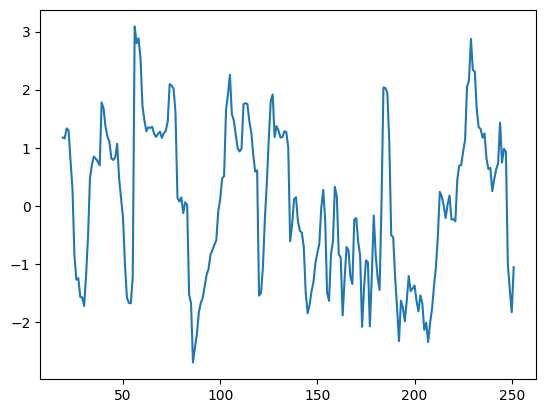

In [54]:
#CCI
def commodity_channel_index(df, n):
    PP = (df['High'] + df['Low'] + df['Close']) / 3
    CCI = pd.Series((PP - PP.rolling(n, min_periods=n).mean()) / PP.rolling(n, min_periods=n).std(),
                    name='CCI_' + str(n))
    df = df.join(CCI)
    return df
plt.plot(commodity_channel_index(data_roku,20)['CCI_20'])
plt.show()

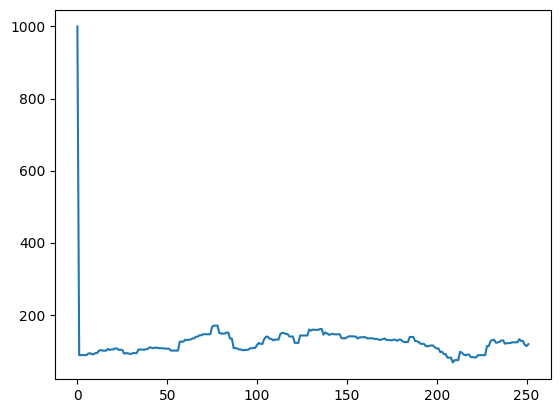

In [42]:
#NVI
def negative_volume_index(data, periods=255, close_col='Close', vol_col='Volume'):
    data['nvi'] = 0.

    for index, row in data.iterrows():
        if index > 0:
            prev_nvi = data.at[index - 1, 'nvi']
            prev_close = data.at[index - 1, close_col]
            if row[vol_col] < data.at[index - 1, vol_col]:
                nvi = prev_nvi + (row[close_col] - prev_close / prev_close * prev_nvi)
            else:
                nvi = prev_nvi
        else:
            nvi = 1000
        data.at[index, 'nvi'] = nvi
    data['nvi_ema'] = data['nvi'].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean()

    return data


plt.plot((negative_volume_index(data_roku))['nvi'])
plt.show()

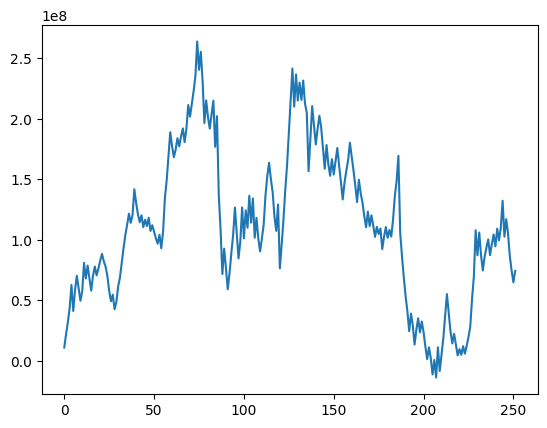

In [43]:
#On Balance Volume (OBV)
def on_balance_volume(data, trend_periods=21, close_col='Close', vol_col='Volume'):
    for index, row in data.iterrows():
        if index > 0:
            last_obv = data.at[index - 1, 'obv']
            if row[close_col] > data.at[index - 1, close_col]:
                current_obv = last_obv + row[vol_col]
            elif row[close_col] < data.at[index - 1, close_col]:
                current_obv = last_obv - row[vol_col]
            else:
                current_obv = last_obv
        else:
            last_obv = 0
            current_obv = row[vol_col]

        data.at[index, 'obv']=current_obv

    data['obv_ema' + str(trend_periods)] = data['obv'].ewm(ignore_na=False, min_periods=0, com=trend_periods,
                                                           adjust=True).mean()

    return data
plt.plot((on_balance_volume(data_roku))['obv'])
plt.show()

In [44]:
from pyti.exponential_moving_average import (
    exponential_moving_average as ema
    )
#price oscillator
def price_oscillator(data, short_period, long_period):
    catch_errors.check_for_period_error(data, short_period)
    catch_errors.check_for_period_error(data, long_period)

    ema_short = ema(data, short_period)
    ema_long = ema(data, long_period)

    po = ((ema_short - ema_long) / ema_long) * 100
    return po
plt.plot(price_oscillator(data_roku, 5, 20))
plt.show()

KeyError: 4

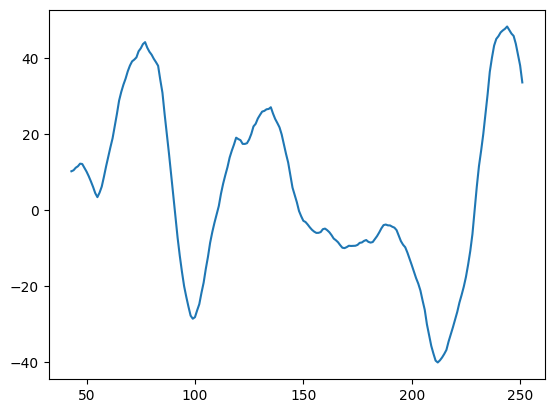

In [56]:
#KST
def kst_oscillator(df, r1, r2, r3, r4, n1, n2, n3, n4):
    M = df['Close'].diff(r1 - 1)
    N = df['Close'].shift(r1 - 1)
    ROC1 = M / N
    M = df['Close'].diff(r2 - 1)
    N = df['Close'].shift(r2 - 1)
    ROC2 = M / N
    M = df['Close'].diff(r3 - 1)
    N = df['Close'].shift(r3 - 1)
    ROC3 = M / N
    M = df['Close'].diff(r4 - 1)
    N = df['Close'].shift(r4 - 1)
    ROC4 = M / N
    KST = pd.Series(
        ROC1.rolling(n1).sum() + ROC2.rolling(n2).sum() * 2 + ROC3.rolling(n3).sum() * 3 + ROC4.rolling(n4).sum() * 4,
        name='KST_' + str(r1) + '_' + str(r2) + '_' + str(r3) + '_' + str(r4) + '_' + str(n1) + '_' + str(
            n2) + '_' + str(n3) + '_' + str(n4))
    df = df.join(KST)
    return df
plt.plot(kst_oscillator(data_roku, 10, 15, 20, 30, 10, 10, 10, 15)['KST_10_15_20_30_10_10_10_15'])
plt.show()

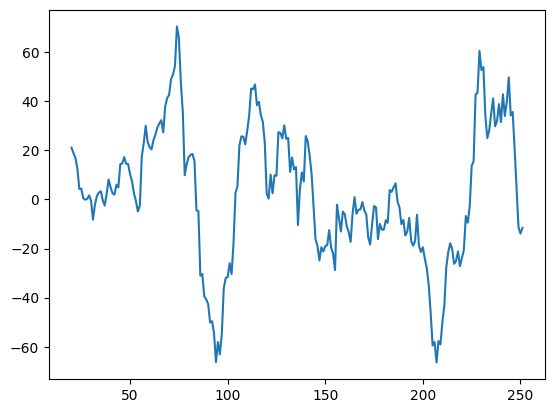

In [46]:
#momentum
def momentum(df, n):
    M = pd.Series(df['Close'].diff(n), name='Momentum_' + str(n))
    df = df.join(M)
    return df
plt.plot(momentum(data_roku,20)['Momentum_20'])
plt.show()

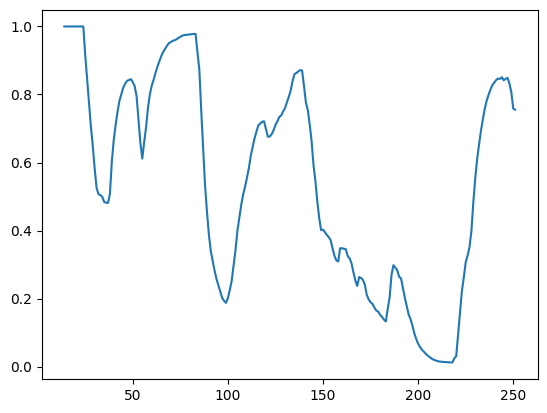

In [47]:
# Relative Strenght Index
def rsi(data, periods=14, close_col='Close'):
    data['rsi_u'] = 0.
    data['rsi_d'] = 0.
    data['rsi'] = 0.

    for index, row in data.iterrows():
        if index >= periods:

            prev_close = data.at[index - periods, close_col]
            if prev_close < row[close_col]:
                data.at[index, 'rsi_u'] = row[close_col] - prev_close
            elif prev_close > row[close_col]:
                data.at[index, 'rsi_d'] = prev_close - row[close_col]

    data['rsi'] = data['rsi_u'].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean() / (
                data['rsi_u'].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean() + data['rsi_d'].ewm(
            ignore_na=False, min_periods=0, com=periods, adjust=True).mean())

    data = data.drop(['rsi_u', 'rsi_d'], axis=1)

    return data


plt.plot((rsi(data_roku))['rsi'])
plt.show()


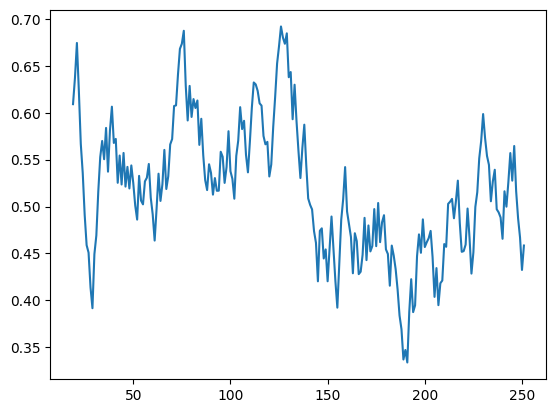

In [48]:
#Stochastic Oscillator
def stochastic_oscillator_d(df, n):
    SOk = pd.Series((df['Close'] - df['Low']) / (df['High'] - df['Low']), name='SO%k')
    SOd = pd.Series(SOk.ewm(span=n, min_periods=n).mean(), name='SO%d_' + str(n))
    df = df.join(SOd)
    return df
plt.plot(stochastic_oscillator_d(data_roku, 20)['SO%d_20'])
plt.show()

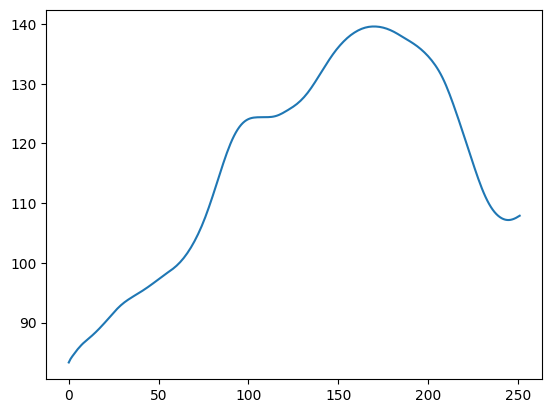

In [49]:
# TRIX
def trix(data, periods=14, signal_periods=9, close_col='Close'):
    data['trix'] = data[close_col].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean()
    data['trix'] = data['trix'].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean()
    data['trix'] = data['trix'].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean()
    data['trix_signal'] = data['trix'].ewm(ignore_na=False, min_periods=0, com=signal_periods, adjust=True).mean()

    return data


plt.plot((trix(data_roku))['trix'])
plt.show()

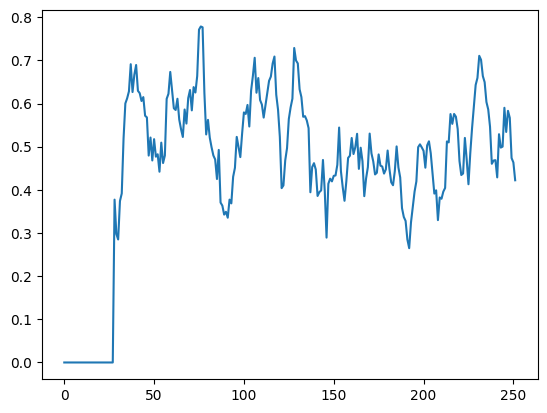

In [50]:
# Ultimate Oscillator
def ultimate_oscillator(data, period_1=7, period_2=14, period_3=28, high_col='High', low_col='Low', close_col='Close'):
    data['ultimate_oscillator'] = 0.
    data['uo_bp'] = 0.
    data['uo_tr'] = 0.
    data['uo_avg_1'] = 0.
    data['uo_avg_2'] = 0.
    data['uo_avg_3'] = 0.

    for index, row in data.iterrows():
        if index > 0:

            bp = row[close_col] - min(row[low_col], data.at[index - 1, close_col])
            tr = max(row[high_col], data.at[index - 1, close_col]) - min(row[low_col], data.at[index - 1, close_col])

            data.at[index, 'uo_bp'] = bp
            data.at[index, 'uo_tr'] = tr
            if index >= period_1:
                uo_avg_1 = sum(data['uo_bp'][index - period_1:index]) / sum(data['uo_tr'][index - period_1:index])
                data.at[index, 'uo_avg_1'] = uo_avg_1
            if index >= period_2:
                uo_avg_2 = sum(data['uo_bp'][index - period_2:index]) / sum(data['uo_tr'][index - period_2:index])
                data.at[index, 'uo_avg_2'] = uo_avg_2
            if index >= period_3:
                uo_avg_3 = sum(data['uo_bp'][index - period_3:index]) / sum(data['uo_tr'][index - period_3:index])
                data.at[index, 'uo_avg_3'] = uo_avg_3
                uo = (4 * uo_avg_1 + 2 * uo_avg_2 + uo_avg_3) / 7
                data.at[index, 'ultimate_oscillator'] = uo

    data = data.drop(['uo_bp', 'uo_tr', 'uo_avg_1', 'uo_avg_2', 'uo_avg_3'], axis=1)

    return data


plt.plot((ultimate_oscillator(data_roku))['ultimate_oscillator'])
plt.show()

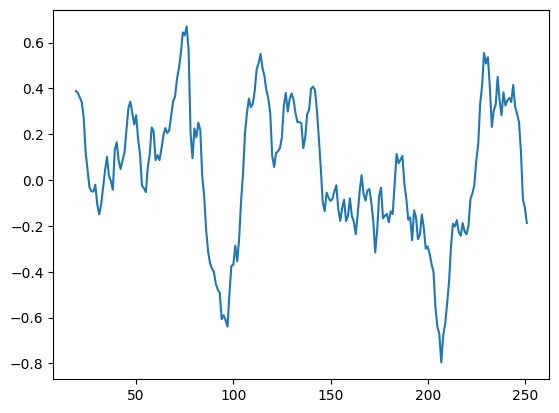

In [51]:
#vortex indicator
def vortex_indicator(df, n):
    i = 0
    TR = [0]
    while i < df.index[-1]:
        Range = max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
        TR.append(Range)
        i = i + 1
    i = 0
    VM = [0]
    while i < df.index[-1]:
        Range = abs(df.loc[i + 1, 'High'] - df.loc[i, 'Low']) - abs(df.loc[i + 1, 'Low'] - df.loc[i, 'High'])
        VM.append(Range)
        i = i + 1
    VI = pd.Series(pd.Series(VM).rolling(n).sum() / pd.Series(TR).rolling(n).sum(), name='Vortex_' + str(n))
    df = df.join(VI)
    return df
plt.plot(vortex_indicator(data_roku,20)['Vortex_20'])
plt.show()


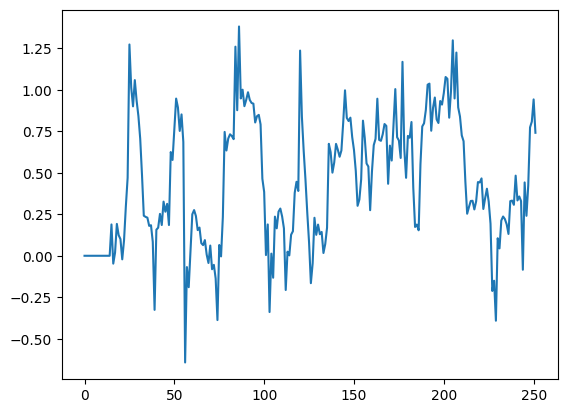

In [53]:
#williams%
def williams_r(data, periods=14, high_col='High', low_col='Low', close_col='Close'):
    data['williams_r'] = 0.

    for index, row in data.iterrows():
        if index > periods:
            data.at[index, 'williams_r']=((max(data[high_col][index - periods:index]) - row[close_col]) /
                                                 (max(data[high_col][index - periods:index]) - min(
                                                     data[low_col][index - periods:index])))

    return data
plt.plot(williams_r(data_roku)['williams_r'])
plt.show()